In [1]:
#Import all the needed libraries
import os
import numpy as np
import pandas as pd
import warnings
import re
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
import mpu
from math import radians, cos, sin, asin, sqrt

warnings.filterwarnings("ignore")

In [2]:
from sklearn.feature_selection import RFECV, f_classif, SelectPercentile
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from category_encoders import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute._iterative import IterativeImputer
from sklearn.experimental import enable_iterative_imputer

import plotly.graph_objects as go
import plotly_express as px
import seaborn as sns
import datetime
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, t
import scipy.stats as stats
import math
import collections

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from mizani.formatters import percent_format
from plotnine import *
import matplotlib.pyplot as plt



from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [4]:
#Check the current working directory
os.getcwd()

'C:\\Users\\Имя'

In [5]:
# Define all the helping functions
####################################################
# Import packages
####################################################
import numpy as np
import copy
import pandas as pd
from plotnine import *


####################################################
# Define global vars
####################################################
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]


####################################################
# Define helper functions
####################################################
def seq(start, stop, by, round_n=3):
    return [round(x, round_n) for x in list(np.arange(start, stop, by))]


def skew(l, round_n=3):
    return round((np.mean(l) - np.median(l)) / np.std(l), round_n)


def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

def create_calibration_plot(
    data,
    file_name,
    prob_var,
    actual_var,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    plot = (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(
            color=color[0],
            size=1,
            alpha=0.7,
            show_legend=False,
            na_rm=True,
        )
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
    )

    return plot


def poly(x, degree=1):
    """
    Fit Polynomial
    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.
    """
    d = {}
    for i in range(degree+1):
        if i == 1:
            d['x'] = x
        else:
            d[f'x**{i}'] = np.power(x, i)
    return pd.DataFrame(d)

# Part I - Data cleaning and loading

For my project I use data set for Airbnb listings for San Diego available from Inside Airbnb website. Initial dataset has 9673 observations and is collected for the data 25th of September 2021.

In [6]:
#First I just import the raw data
data = pd.read_csv('listings.csv', delimiter = ',',dtype ='unicode')

In [7]:
#Checking what I imorted
data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,https://www.airbnb.com/rooms/5570,20210925150545,2021-09-25,Ocean front condo on the sand,Missionbeachretreat. Great Ocean Front Condo...,While some may compare San Diego’s Mission Bea...,https://a0.muscache.com/pictures/d3342744-140a...,8435,https://www.airbnb.com/users/show/8435,...,NaN,NaN,NaN,NaN,f,3,3,0,0,NaN
1,29967,https://www.airbnb.com/rooms/29967,20210925150545,2021-09-26,"Great home, 10 min walk to Beach","This 2 bedroom, 2 full bathroom home offers al...",NaN,https://a0.muscache.com/pictures/76103867/c9b5...,129123,https://www.airbnb.com/users/show/129123,...,4.93,4.83,4.83,NaN,f,5,5,0,0,0.52
2,38245,https://www.airbnb.com/rooms/38245,20210925150545,2021-09-26,Point Loma: Den downstairs,Stay in a 1928 Spanish Style home. Den is dow...,"This neighborhood is an expensive, high-end Po...",https://a0.muscache.com/pictures/f3073822-e493...,164137,https://www.airbnb.com/users/show/164137,...,4.79,4.61,4.4,NaN,f,3,0,3,0,1.46
3,39516,https://www.airbnb.com/rooms/39516,20210925150545,2021-09-26,Art Studio Retreat/Rustic Cabin,We love having explorers from all over the wor...,"We love our eclectic neighborhood, with a smal...",https://a0.muscache.com/pictures/2ee5c482-c48f...,169649,https://www.airbnb.com/users/show/169649,...,4.96,4.9,4.94,NaN,f,1,1,0,0,3.38
4,54001,https://www.airbnb.com/rooms/54001,20210925150545,2021-09-26,"La Jolla Cottage Blocks to Ocn; 2Bdms, 1Bth.","Separate charming cottage behind main home, 2 ...","Tranquility, stately trees, meditative, zen-fu...",https://a0.muscache.com/pictures/47035b04-633c...,252692,https://www.airbnb.com/users/show/252692,...,4.97,4.97,4.88,NaN,f,2,1,1,0,5.47


# Getting rid from not needed columns

In [8]:
#Look at all columns names
for col in data:
    print(col)

id
listing_url
scrape_id
last_scraped
name
description
neighborhood_overview
picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
latitude
longitude
property_type
room_type
accommodates
bathrooms
bathrooms_text
bedrooms
beds
amenities
price
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
first_review
last_review
review_scores_rating
review_scores_accuracy
review_sc

In [9]:
# First define columns which aren't needed just logically
drops = [
    'listing_url',
    'name', #no information I could use witout text analysis
    'host_location', #I already know I look at San Diego
    'scrape_id',
    'last_scraped',
    'description',
    'neighborhood_overview',
    'picture_url',
    'host_url',
    'host_name',
    'host_about',
    'host_thumbnail_url',
    'host_picture_url',
    'neighbourhood_group_cleansed',
    'bathrooms', #empty
    'minimum_minimum_nights',
    'maximum_minimum_nights', 
    'minimum_maximum_nights',
    'maximum_maximum_nights',
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm',
    'calendar_updated',
    'calendar_last_scraped', 
    'license'   
]
data.drop(columns = drops, inplace = True) #drop all not needed columns

In [10]:
#look how it looks now
data.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,8435,2009-02-23,NaN,NaN,100%,f,Mission Beach,3,3,...,NaN,NaN,NaN,NaN,f,3,3,0,0,NaN
1,29967,129123,2010-05-21,within a few hours,100%,63%,f,Pacific Beach,6,6,...,4.95,4.93,4.83,4.83,f,5,5,0,0,0.52
2,38245,164137,2010-07-12,within an hour,100%,50%,f,Loma Portal,3,3,...,4.71,4.79,4.61,4.4,f,3,0,3,0,1.46
3,39516,169649,2010-07-17,NaN,NaN,NaN,t,North Park,1,1,...,4.97,4.96,4.9,4.94,f,1,1,0,0,3.38
4,54001,252692,2010-10-04,within a few hours,100%,84%,t,La Jolla,5,5,...,4.96,4.97,4.97,4.88,f,2,1,1,0,5.47


In [11]:
[col for col in data.columns if data[col].isnull().any()] # Look at the columns which have NAs

['host_since',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [12]:
#Function to define table with missing values
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [13]:
missing_zero_values_table(data) #print table with missing values

Your selected dataframe has 50 columns and 9672 Rows.
There are 24 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
neighbourhood,0,2787,28.8,2787,28.8,object
review_scores_value,0,1249,12.9,1249,12.9,object
review_scores_location,0,1249,12.9,1249,12.9,object
review_scores_checkin,0,1249,12.9,1249,12.9,object
review_scores_communication,0,1247,12.9,1247,12.9,object
review_scores_cleanliness,0,1247,12.9,1247,12.9,object
review_scores_accuracy,0,1247,12.9,1247,12.9,object
reviews_per_month,0,1218,12.6,1218,12.6,object
first_review,0,1218,12.6,1218,12.6,object
review_scores_rating,0,1218,12.6,1218,12.6,object


I can see that neigbourhood has a lot of missing data (almost 1/3 of the observations). Looking more carefully into the data I can see that neighourhood information is much better depicted in neighourborhood cleansed (and it has no missing values). Thus, I drop variable neigbourhood. Host neighorborhood sometimes also has missing values. In general it looks very similaer to neighbourhood cleansed, but with more missing values for reason I couldn't identify. I decided to only keep neighborhood cleansed.


In [14]:
data.drop(columns = ['neighbourhood', 'host_neighbourhood'], inplace=True )

In [15]:
data.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,8435,2009-02-23,NaN,NaN,100%,f,3,3,"['email', 'phone', 'kba']",...,NaN,NaN,NaN,NaN,f,3,3,0,0,NaN
1,29967,129123,2010-05-21,within a few hours,100%,63%,f,6,6,"['email', 'phone', 'reviews', 'kba', 'work_ema...",...,4.95,4.93,4.83,4.83,f,5,5,0,0,0.52
2,38245,164137,2010-07-12,within an hour,100%,50%,f,3,3,"['email', 'phone', 'reviews', 'kba']",...,4.71,4.79,4.61,4.4,f,3,0,3,0,1.46
3,39516,169649,2010-07-17,NaN,NaN,NaN,t,1,1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.97,4.96,4.9,4.94,f,1,1,0,0,3.38
4,54001,252692,2010-10-04,within a few hours,100%,84%,t,5,5,"['email', 'phone', 'reviews', 'kba']",...,4.96,4.97,4.97,4.88,f,2,1,1,0,5.47


In [16]:
#Save this data after first cleaning and don't touch it
data.to_csv('airbnb_sd_listings.csv', index='False')

In [17]:
#Open data set
df = pd.read_csv('airbnb_sd_listings.csv', delimiter = ',')

In [18]:
df.head() #check how it looks

,Unnamed: 0,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,5570,8435,2009-02-23,NaN,NaN,100%,f,3.0,3.0,...,NaN,NaN,NaN,NaN,f,3,3,0,0,NaN
1,1,29967,129123,2010-05-21,within a few hours,100%,63%,f,6.0,6.0,...,4.95,4.93,4.83,4.83,f,5,5,0,0,0.52
2,2,38245,164137,2010-07-12,within an hour,100%,50%,f,3.0,3.0,...,4.71,4.79,4.61,4.40,f,3,0,3,0,1.46
3,3,39516,169649,2010-07-17,NaN,NaN,NaN,t,1.0,1.0,...,4.97,4.96,4.90,4.94,f,1,1,0,0,3.38
4,4,54001,252692,2010-10-04,within a few hours,100%,84%,t,5.0,5.0,...,4.96,4.97,4.97,4.88,f,2,1,1,0,5.47


# Check duplicate values

In [19]:
df.shape #store df as a number of rows and columns

(9672, 49)

In [20]:
df = df.drop_duplicates()

In [21]:
df.shape #check rows and columns again - great there was no duplicates

(9672, 49)

# Separate data types

In [22]:
#First, drop id-s which are not characteristic of number - "broken lines"
df.id = pd.to_numeric(df.id, errors = 'coerce') #coerce means that it will try to find numbers which are not definied as numbers and replace this with number


In [23]:
df.shape #nothing was a problem

(9672, 49)

In [24]:
df = df[df.id.notna()] #leave only those without missing values

In [25]:
df.shape

(9672, 49)

In [26]:
# I checked the fact of missing values but that I knew from before that for id there is no missing values

Now I will check data types. There can be the following types I should think about



Numerical (Continuous/Discrete)


Categorical (Binary/Ordinal/Nominal)


Mixed Type


Time

In [27]:
# First categorical variables
cat_df = df.select_dtypes(include=['object', 'bool'])
cat_cols = df.select_dtypes(include=['object', 'bool']).columns.values

In [28]:
cat_cols # look which one are categorical

array(['host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type',
       'bathrooms_text', 'amenities', 'price', 'has_availability',
       'first_review', 'last_review', 'instant_bookable'], dtype=object)

In [29]:
df.shape

(9672, 49)

In [30]:
#Now numerical variables
num_df = df.select_dtypes(include=['int', 'int64','float'])
num_cols = df.select_dtypes(include=['int', 'int64','float']).columns.values

In [31]:
num_cols #which once are numerical

array(['Unnamed: 0', 'id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude',
       'accommodates', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype=object)

In [32]:
# Not forget to check that all features are accounted for
len(num_cols) + len(cat_cols) == df.shape[1] # After debugging and adding int64 everything works

True

In [33]:
#Let's look at numerical variables
num_df.head().transpose() # Looks okay, there are missing values but with them I will deal later

,0,1,2,3,4
Unnamed: 0,0.00000,1.00000,2.00000,3.00000,4.00000
id,5570.00000,29967.00000,38245.00000,39516.00000,54001.00000
host_id,8435.00000,129123.00000,164137.00000,169649.00000,252692.00000
host_listings_count,3.00000,6.00000,3.00000,1.00000,5.00000
host_total_listings_count,3.00000,6.00000,3.00000,1.00000,5.00000
latitude,32.78481,32.80751,32.74217,32.73004,32.81301
longitude,-117.25313,-117.25760,-117.21931,-117.11932,-117.26856
accommodates,6.00000,8.00000,1.00000,2.00000,4.00000
bedrooms,2.00000,2.00000,1.00000,1.00000,2.00000
beds,4.00000,3.00000,1.00000,1.00000,3.00000


In [34]:
# Let's look at categorical variables
cat_df.head().transpose()

,0,1,2,3,4
host_since,2009-02-23,2010-05-21,2010-07-12,2010-07-17,2010-10-04
host_response_time,NaN,within a few hours,within an hour,NaN,within a few hours
host_response_rate,NaN,100%,100%,NaN,100%
host_acceptance_rate,100%,63%,50%,NaN,84%
host_is_superhost,f,f,f,t,t
host_verifications,"['email', 'phone', 'kba']","['email', 'phone', 'reviews', 'kba', 'work_ema...","['email', 'phone', 'reviews', 'kba']","['email', 'phone', 'reviews', 'jumio', 'offlin...","['email', 'phone', 'reviews', 'kba']"
host_has_profile_pic,t,t,t,t,t
host_identity_verified,t,t,t,t,t
neighbourhood_cleansed,Mission Bay,Pacific Beach,Roseville,North Hills,La Jolla
property_type,Entire condominium (condo),Entire bungalow,Private room in residential home,Tiny house,Entire residential home


Categorical variables don't look that good. There are the following problems:


1) There are time variables

2) I want to create dummies for binary categorical variables ( for ex, with f, t)

3) I want to separate price in numerical variable deleting the dollar sign

4) I want to make percentages a numerical variables in percentage points

5) I want to delete word bath in bathrooms to get the number of bathrooms 

6) I want to do smth with variables containing multiple variables (for ex, host verifications and amenities)

# Tranforming and cleaning categorical variables

Time variables

In [35]:
# First, I want to create a reference for the 'time since'. For this, I create variable today
# Today refers to 25th of September 2021 for which the data from San Diego is scraped
today = pd.to_datetime('2021-09-25')

In [36]:
time_var = ['host_since','first_review', 'last_review'] #putting together all time variables

In [37]:
for col in time_var: #transfering this columns to date time in data frame
    df[col] = pd.to_datetime(df[col], infer_datetime_format=True)

In [38]:
df.host_since.describe()

count                    9581
unique                   2489
top       2016-08-05 00:00:00
freq                      202
first     2009-02-23 00:00:00
last      2021-09-22 00:00:00
Name: host_since, dtype: object

In [39]:
# Creating date features for each of the time var columns
for col in time_var:
    df[col+"_days"] = (today - df[col]).apply(lambda x: x.days)

In [40]:
df.head() #look what I got - looks like what is needed

,Unnamed: 0,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,...,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_days,first_review_days,last_review_days
0,0,5570,8435,2009-02-23,NaN,NaN,100%,f,3.0,3.0,...,NaN,f,3,3,0,0,NaN,4597.0,NaN,NaN
1,1,29967,129123,2010-05-21,within a few hours,100%,63%,f,6.0,6.0,...,4.83,f,5,5,0,0,0.52,4145.0,4076.0,47.0
2,2,38245,164137,2010-07-12,within an hour,100%,50%,f,3.0,3.0,...,4.40,f,3,0,3,0,1.46,4093.0,3002.0,41.0
3,3,39516,169649,2010-07-17,NaN,NaN,NaN,t,1.0,1.0,...,4.94,f,1,1,0,0,3.38,4088.0,3549.0,558.0
4,4,54001,252692,2010-10-04,within a few hours,100%,84%,t,5.0,5.0,...,4.88,f,2,1,1,0,5.47,4009.0,1489.0,5.0


In [41]:
df.head()

,Unnamed: 0,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,...,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_days,first_review_days,last_review_days
0,0,5570,8435,2009-02-23,NaN,NaN,100%,f,3.0,3.0,...,NaN,f,3,3,0,0,NaN,4597.0,NaN,NaN
1,1,29967,129123,2010-05-21,within a few hours,100%,63%,f,6.0,6.0,...,4.83,f,5,5,0,0,0.52,4145.0,4076.0,47.0
2,2,38245,164137,2010-07-12,within an hour,100%,50%,f,3.0,3.0,...,4.40,f,3,0,3,0,1.46,4093.0,3002.0,41.0
3,3,39516,169649,2010-07-17,NaN,NaN,NaN,t,1.0,1.0,...,4.94,f,1,1,0,0,3.38,4088.0,3549.0,558.0
4,4,54001,252692,2010-10-04,within a few hours,100%,84%,t,5.0,5.0,...,4.88,f,2,1,1,0,5.47,4009.0,1489.0,5.0


In [42]:
# Now time var colums can be dropped from initial data set
df.drop(columns = time_var, inplace=True)

In [43]:
df.head() #check number of columns now - good

,Unnamed: 0,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_days,first_review_days,last_review_days
0,0,5570,8435,NaN,NaN,100%,f,3.0,3.0,"['email', 'phone', 'kba']",...,NaN,f,3,3,0,0,NaN,4597.0,NaN,NaN
1,1,29967,129123,within a few hours,100%,63%,f,6.0,6.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",...,4.83,f,5,5,0,0,0.52,4145.0,4076.0,47.0
2,2,38245,164137,within an hour,100%,50%,f,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",...,4.40,f,3,0,3,0,1.46,4093.0,3002.0,41.0
3,3,39516,169649,NaN,NaN,NaN,t,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.94,f,1,1,0,0,3.38,4088.0,3549.0,558.0
4,4,54001,252692,within a few hours,100%,84%,t,5.0,5.0,"['email', 'phone', 'reviews', 'kba']",...,4.88,f,2,1,1,0,5.47,4009.0,1489.0,5.0


Creating dummy variables for binary categorical variables

In [44]:
# I have 5 columns with f,t for which I want to have 0, 1
bi_col = ['host_is_superhost','host_has_profile_pic','host_identity_verified','has_availability','instant_bookable']


In [45]:
# Now transform df in needed way
for col in bi_col:
    df[col] = df[col].map({'f':0, 't':1})

In [46]:
# let's see
df.instant_bookable.head(20) #looks good

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    1
13    1
14    1
15    0
16    0
17    0
18    0
19    1
Name: instant_bookable, dtype: int64

Price and percentage variables transformation

Here the problem was that numbers with ',' (for example, 2020,564) weren't recongised as numeric and were transfered as NA 

In [47]:
df.price = df.price.str.replace("\\$", "").str.replace(',', '') #replace dollar sign and account for the fact that numbers can 
    #be higher than in London data and have ","

In [48]:
df.price.head(100)

0     2050.00
1      225.00
2       74.00
3       74.00
4      258.00
       ...   
95     700.00
96      61.00
97      62.00
98     128.00
99    1324.00
Name: price, Length: 100, dtype: object

Making percentage a numerical variable

In [49]:
df.host_response_rate.head()

0     NaN
1    100%
2    100%
3     NaN
4    100%
Name: host_response_rate, dtype: object

In [50]:
def repl(m): return m.group(1)


df['host_response_rate'] = df['host_response_rate'].str.replace(
   r'(\d+)%', repl).astype(float)

In [51]:
df.host_response_rate.head() #done

0      NaN
1    100.0
2    100.0
3      NaN
4    100.0
Name: host_response_rate, dtype: float64

Getting number of bathes

In [52]:
#Firstly, in the data there is one strange observation with 27.5 baths for apartment with 2 bedrooms - drop it
df.shape #check how df looks


(9672, 49)

In [53]:
df = df[df.bathrooms_text != '27.5 baths'] # get df without these 27.5 baths

In [54]:
df.shape #great I got what I wanted

(9671, 49)

In [55]:
# I have depicted some baths decoded as as Half bath, private half bath and shared half bath
# I want to replace it
df['bathrooms_text'] = np.where(df['bathrooms_text'] == 'Half-bath', 0.5, df['bathrooms_text'])
df['bathrooms_text'] = np.where(df['bathrooms_text'] == 'Shared half-bath', 0.5, df['bathrooms_text'])
df['bathrooms_text'] = np.where(df['bathrooms_text'] == 'Private half-bath', 0.5, df['bathrooms_text'])

In [56]:
df['bathrooms_text'].describe()

count       9666
unique        36
top       1 bath
freq        4465
Name: bathrooms_text, dtype: object

In [57]:
# Let's look at this colum now
df['bathrooms_text'].head(20)

0             1 bath
1            2 baths
2      1 shared bath
3             1 bath
4             1 bath
5             1 bath
6             1 bath
7             1 bath
8     1 private bath
9     1 private bath
10    1 private bath
11    1 private bath
12            1 bath
13         2.5 baths
14           2 baths
15            1 bath
16            1 bath
17     1 shared bath
18    2 shared baths
19            1 bath
Name: bathrooms_text, dtype: object

In [58]:
df['bathrooms_text'] = df['bathrooms_text'].astype(str) #convert everything in bathroom column to string


In [59]:
# Let's use regex to find the number of baths in the text and add what we found to a list
# Self remark - that is a correct way to use regax function for the future to avoid getting empty values from it
df['bath']= df['bathrooms_text'].apply(lambda x: re.findall(r"(?<![a-zA-Z])[-+]?\d*\.?\d+", x))
df['bath'] = [val[0] if len(val)>0 else np.nan for val in df['bath']]

Description of the regex function

(?<![a-zA-Z]) - a negative lookbehind that makes sure there is no ASCII letter before the current location

[-+]? - an optional + or -

\d* - zero or more digits

\.? - an optional dot

\d+ - 1+ digits

In [60]:
df.bath.head(20) #look how it looks - good

0       1
1       2
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13    2.5
14      2
15      1
16      1
17      1
18      2
19      1
Name: bath, dtype: object

In [61]:
df.shape

(9671, 50)

In [62]:
# drop the column with bathes decoded as text
df.drop(columns = 'bathrooms_text', inplace=True)

In [63]:
df.shape# great, got what is needed

(9671, 49)

Transformation of variables containing multiple variables (host verification and amenities)

In [64]:
# First, define a function for striping info inside the list (getting rid of empty spaces in my case)
def striplist(l):
    return([x.strip() for x in l])

In [65]:
#Now let's replace all not needed symbols and apply defined striplist
df['host_verifications'] = df['host_verifications'].str.replace('[', '').str.replace(']', '').str.replace("'",
                                                                                                                  '').str.lower().str.split(',').apply(striplist)


In [66]:
df['host_verifications'] #what I get in the end is just list of items in each raw

0                                     [email, phone, kba]
1                [email, phone, reviews, kba, work_email]
2                            [email, phone, reviews, kba]
3       [email, phone, reviews, jumio, offline_governm...
4                            [email, phone, reviews, kba]
                              ...                        
9667    [email, phone, offline_government_id, selfie, ...
9668    [email, phone, google, reviews, jumio, governm...
9669    [email, phone, facebook, reviews, offline_gove...
9670    [email, phone, google, reviews, jumio, offline...
9671               [email, phone, facebook, reviews, kba]
Name: host_verifications, Length: 9671, dtype: object

In [67]:
#Do the same for amenities with small modifications of replacements
df['amenities'] = df['amenities'].str.replace('[', '').str.replace(']',
                                                                           '').str.replace('"', '').str.lower().str.split(',').apply(striplist)


In [68]:
df['amenities'] #good, that is what I wanted

0       [refrigerator, stove, dishes and silverware, b...
1       [shampoo, first aid kit, patio or balcony, kit...
2       [shampoo, dishes and silverware, first aid kit...
3       [shampoo, refrigerator, dishes and silverware,...
4       [shampoo, dishes and silverware, kirkland cond...
                              ...                        
9667    [shampoo, refrigerator, luggage dropoff allowe...
9668    [shampoo, refrigerator, stove, dishes and silv...
9669    [shampoo, first aid kit, kitchen, hair dryer, ...
9670    [shampoo, refrigerator, stove, cleaning before...
9671                [long term stays allowed, essentials]
Name: amenities, Length: 9671, dtype: object

I also want to create a column in initial data set with variable number of amenities

In [69]:
df['n_amenities'] = df['amenities'].str.len()


In [70]:
df['n_amenities'].head()

0    28
1    22
2    30
3    26
4    64
Name: n_amenities, dtype: int64

In [71]:
#Now let's binarize the lists
# first, for amenities
mlb = MultiLabelBinarizer()
amenities_df = pd.DataFrame(mlb.fit_transform(
    df['amenities']), columns=mlb.classes_, index=df.index)

In [72]:
amenities_df #basically it looks like df with binary variables

,,1 travel size bottle conditioner,1 travel size bottle shampoo,100% pure plant extracts body wash by kirkland signature body soap,100% vegan & cruelty-free,120\ hdtv with chromecast,18\ hdtv with amazon prime video,1950\u2019s wedgewood gas stove,1950\u2019s wedgewood oven,2 burner hotplate electric stove,...,wolf stainless steel gas stove,wolf stainless steel induction stove,wolf stainless steel oven,wolf stainless steel stove,wolfe stainless steel gas stove,yamaha - download the controller app sound system with bluetooth and aux,yamaha bluetooth sound system,yamaha sound system with bluetooth and aux,z-line dual-fuel (gas & electric) professional range oven stainless steel gas stove,zest body soap
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9669,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
#second, for host verifications
mlb = MultiLabelBinarizer()
host_verif_df = pd.DataFrame(mlb.fit_transform(
    df['host_verifications']), columns=mlb.classes_, index=df.index)


In [74]:
host_verif_df #also df with binary variables

,email,facebook,google,government_id,identity_manual,jumio,kba,manual_offline,manual_online,none,offline_government_id,phone,reviews,selfie,sent_id,weibo,work_email,yahoo,zhima_selfie
0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0
2,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
3,1,0,0,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9667,1,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0
9668,1,0,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
9669,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0
9670,1,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0


In [75]:
df.shape

(9671, 50)

In [76]:
# delete these two columns from initial df
df = df.drop(columns = ['host_verifications', 'amenities'], axis=1) 

In [77]:
df.shape

(9671, 48)

In [78]:
#Now concan 2 created datasets with initial df
df = pd.concat([df, amenities_df, host_verif_df], axis=1)

In [79]:
df.head()

,Unnamed: 0,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,...,none,offline_government_id,phone,reviews,selfie,sent_id,weibo,work_email,yahoo,zhima_selfie
0,0,5570,8435,NaN,NaN,100%,0.0,3.0,3.0,1.0,...,0,0,1,0,0,0,0,0,0,0
1,1,29967,129123,within a few hours,100.0,63%,0.0,6.0,6.0,1.0,...,0,0,1,1,0,0,0,1,0,0
2,2,38245,164137,within an hour,100.0,50%,0.0,3.0,3.0,1.0,...,0,0,1,1,0,0,0,0,0,0
3,3,39516,169649,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,0,1,1,1,0,0,0,0,0,0
4,4,54001,252692,within a few hours,100.0,84%,1.0,5.0,5.0,1.0,...,0,0,1,1,0,0,0,0,0,0


In [80]:
cl = df.columns.values

In [81]:
for c in cl: #get colum values of this new df with amenities and host verifications
    print(c) #now I indeed didn't lose bathes anywhere

Unnamed: 0
id
host_id
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_listings_count
host_total_listings_count
host_has_profile_pic
host_identity_verified
neighbourhood_cleansed
latitude
longitude
property_type
room_type
accommodates
bedrooms
beds
price
minimum_nights
maximum_nights
has_availability
availability_30
availability_60
availability_90
availability_365
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
instant_bookable
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
reviews_per_month
host_since_days
first_review_days
last_review_days
bath
n_amenities

1 travel size bottle conditioner
1 travel size bottle shampoo
100% pure plant extracts body wash by kirkla

# Dealing with Missing Values

In [82]:
na = df.isna().sum() # I remember from previos tables where I have na's, just want to see whether I have any missings in new cols
for col in na: # No, I don't great
    print(col)

0
0
0
1180
1180
1069
91
91
91
91
91
0
0
0
0
0
0
986
73
0
0
0
0
0
0
0
0
0
0
0
1218
1247
1247
1249
1247
1249
1249
0
0
0
0
0
1218
91
1218
1218
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Columns with missing values

In [83]:
# To decide whether I need to drop any columns with missing values at all, I will visualize columns with biggest proportion of NAs
# Decision rule taken by me - if there are more than 30% NAs, I will drop a column
# Plotting columns where more than 5% values are missing
prop_na = df.isna().sum()/len(df)
prop_na_05 = prop_na[prop_na > .05]
prop_na_05 = prop_na_05.sort_values(0, ascending=True).reset_index()

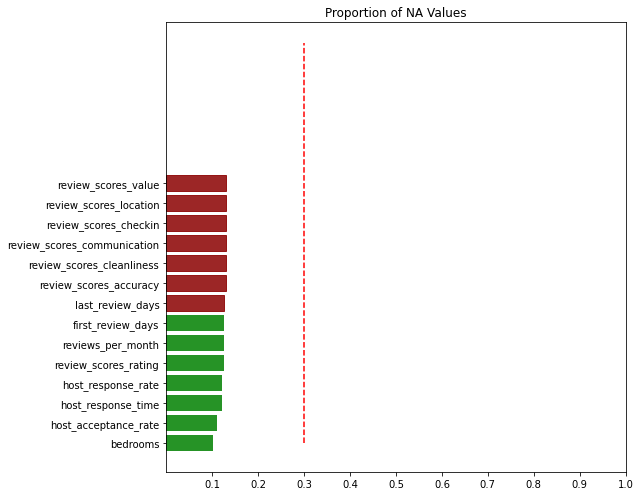

In [84]:
# Now plot on graph
plt.figure(figsize=(9, 7))

barh = plt.barh(prop_na_05['index'], prop_na_05[0], alpha=0.85, color='green')
for i in range(7):
    i += 1
    barh[-i].set_color('darkred')

plt.title('Proportion of NA Values')
plt.vlines(x=.3, ymin=0, ymax=20, color='red', linestyles='dashed')
plt.xticks(np.arange(.1, 1.01, .1))

plt.tight_layout()

Non of the columns has 30% of NAs - I won't drop any of them fully

Rows with missing values

In [85]:
df['sum_na_row'] = df.isna().sum(axis=1)

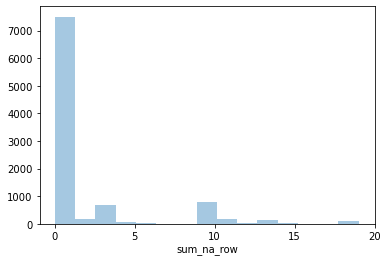

In [86]:
plt.figure()
sns.distplot(df['sum_na_row'], bins=15, kde=False)
plt.xticks(np.arange(0, 21, 5))
plt.show()

There are indeed many rows with around 8-10 or more missing values - let's look at them 

In [87]:
temp = df[df['sum_na_row'] >= 5].isna().any().reset_index() # based on the previos graph I will look at the ones missing more than 5
na_cols = temp[temp[0] == True]['index'].values
df[df['sum_na_row'] >= 5][na_cols].transpose()

,0,104,141,162,285,290,329,333,334,341,...,9662,9663,9664,9665,9666,9667,9668,9669,9670,9671
host_response_time,NaN,within a day,within a few hours,NaN,within a day,NaN,within an hour,within an hour,within an hour,within an hour,...,NaN,within an hour,NaN,within an hour,within an hour,within an hour,within an hour,within an hour,within an hour,within an hour
host_response_rate,NaN,58.0,100.0,NaN,100.0,NaN,100.0,100.0,100.0,100.0,...,NaN,97.0,NaN,97.0,100.0,100.0,100.0,100.0,97.0,100.0
host_acceptance_rate,100%,18%,81%,0%,50%,NaN,92%,92%,92%,92%,...,NaN,100%,NaN,99%,100%,96%,98%,88%,100%,100%
host_is_superhost,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
host_listings_count,3.0,135.0,3.0,0.0,2.0,1.0,41.0,41.0,41.0,41.0,...,4.0,91.0,1.0,18.0,3.0,1.0,12.0,6.0,91.0,4.0
host_total_listings_count,3.0,135.0,3.0,0.0,2.0,1.0,41.0,41.0,41.0,41.0,...,4.0,91.0,1.0,18.0,3.0,1.0,12.0,6.0,91.0,4.0
host_has_profile_pic,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
host_identity_verified,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
bedrooms,2.0,2.0,1.0,5.0,3.0,1.0,3.0,4.0,3.0,2.0,...,2.0,3.0,2.0,2.0,2.0,NaN,8.0,1.0,1.0,NaN
beds,4.0,3.0,3.0,5.0,2.0,1.0,5.0,6.0,6.0,4.0,...,4.0,6.0,0.0,7.0,3.0,1.0,8.0,2.0,5.0,1.0


Seems that in reviews raws values are missing just because there is no review. I don't want to delete these ones - I want to replace them with 0-s

In [88]:
review_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
               'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
               'review_scores_value', 'reviews_per_month', 'first_review_days', 'last_review_days'] #define these review columns

In [89]:
df[review_cols] = df[review_cols].fillna(value=0) #fill na with 0-s for such columns

In [90]:
df[review_cols].head(20) #look at what I got - good

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,first_review_days,last_review_days
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
1,4.85,4.85,4.69,4.95,4.93,4.83,4.83,0.52,4076.0,47.0
2,4.32,4.35,4.21,4.71,4.79,4.61,4.40,1.46,3002.0,41.0
3,4.89,4.92,4.89,4.97,4.96,4.90,4.94,3.38,3549.0,558.0
4,4.94,4.92,4.95,4.96,4.97,4.97,4.88,5.47,1489.0,5.0
5,4.77,4.87,4.87,4.93,4.85,4.87,4.79,6.14,3284.0,15.0
6,4.86,4.90,4.85,4.96,4.94,4.81,4.81,9.69,2486.0,5.0
7,5.00,5.00,5.00,5.00,5.00,5.00,5.00,0.06,2311.0,117.0
8,4.83,4.86,4.71,4.87,4.89,4.80,4.87,2.25,2595.0,360.0
9,4.82,4.94,4.88,4.88,4.94,5.00,4.76,0.41,1236.0,344.0


I also have bedrooms and beds columns with missing values. Since it is Airbnb data, most likely it is not the case that the accomodation doesn't have a bed or bedroom and it can be denoted by 0. I also don't want to delete anything there. 
Decision - I will replace by the mode

In [91]:
df.isna().sum()

Unnamed: 0               0
id                       0
host_id                  0
host_response_time    1180
host_response_rate    1180
                      ... 
weibo                    0
work_email               0
yahoo                    0
zhima_selfie             0
sum_na_row               0
Length: 1505, dtype: int64

In [92]:
bb = [ 'bedrooms', 'beds'] # columns I need

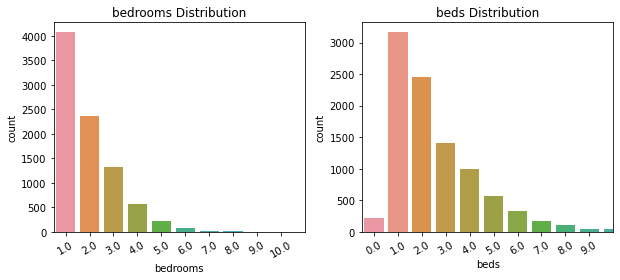

In [93]:
#Plot the modes
plt.figure(figsize=(13, 4))
i = 1
for col in bb:
    plt.subplot(1, 3, i)
    sns.countplot(x=col, data=df)
    plt.title(col+' Distribution')
    plt.xticks(np.arange(0, 10, 1, dtype=np.int64), rotation=30)
    plt.xlim(right=10)
    i += 1

plt.tight_layout()

The decision will be in both cases replace missing values with the mode - 1

In [94]:
df['bedrooms'] = df['bedrooms'].fillna(value=1) 
df['beds'] = df['beds'].fillna(value=1) 

In [95]:
#Let's look again  which missing values I have
missing_zero_values_table(df)

Your selected dataframe has 1505 columns and 9671 Rows.
There are 10 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
host_response_time,0,1180,12.2,1180,12.2,object
host_response_rate,154,1180,12.2,1334,13.8,float64
host_acceptance_rate,0,1069,11.1,1069,11.1,object
host_is_superhost,5511,91,0.9,5602,57.9,float64
host_listings_count,1313,91,0.9,1404,14.5,float64
host_total_listings_count,1313,91,0.9,1404,14.5,float64
host_has_profile_pic,36,91,0.9,127,1.3,float64
host_identity_verified,1572,91,0.9,1663,17.2,float64
host_since_days,0,91,0.9,91,0.9,float64
bath,0,5,0.1,5,0.1,object


Seems that for host response time and host acceptance rate there are no 0-s but on the others hand many NAs - I most likely can replace with 0-s. Response rate has 0-s but NAs seem to correspond with respose time, so for response rate I will also replace

In [96]:
df['host_response_time'] = df['host_response_time'].fillna(value=0) 
df['host_response_rate'] = df['host_response_rate'].fillna(value=0) 
df['host_acceptance_rate'] = df['host_acceptance_rate'].fillna(value=0) 

In [97]:
missing_zero_values_table(df)

Your selected dataframe has 1505 columns and 9671 Rows.
There are 7 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
host_is_superhost,5511,91,0.9,5602,57.9,float64
host_listings_count,1313,91,0.9,1404,14.5,float64
host_total_listings_count,1313,91,0.9,1404,14.5,float64
host_has_profile_pic,36,91,0.9,127,1.3,float64
host_identity_verified,1572,91,0.9,1663,17.2,float64
host_since_days,0,91,0.9,91,0.9,float64
bath,0,5,0.1,5,0.1,object


For all host variables I have 0 values. Thus I take a choice to replace missing values with modes


In [98]:
# But first let's look whether total listings count and listings count look the same
df.host_total_listings_count.head(20)

0      3.0
1      6.0
2      3.0
3      1.0
4      5.0
5      2.0
6      2.0
7      5.0
8      2.0
9      1.0
10     2.0
11     5.0
12     9.0
13     2.0
14     2.0
15     4.0
16    12.0
17     4.0
18     2.0
19     2.0
Name: host_total_listings_count, dtype: float64

In [99]:
df.host_listings_count.head(20) # They do

0      3.0
1      6.0
2      3.0
3      1.0
4      5.0
5      2.0
6      2.0
7      5.0
8      2.0
9      1.0
10     2.0
11     5.0
12     9.0
13     2.0
14     2.0
15     4.0
16    12.0
17     4.0
18     2.0
19     2.0
Name: host_listings_count, dtype: float64

In [100]:
#I will only leave the total listing count
df.drop(columns = 'host_listings_count', inplace = True)

In [101]:
df.head()

,Unnamed: 0,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,offline_government_id,phone,reviews,selfie,sent_id,weibo,work_email,yahoo,zhima_selfie,sum_na_row
0,0,5570,8435,0,0.0,100%,0.0,3.0,1.0,1.0,...,0,1,0,0,0,0,0,0,0,12
1,1,29967,129123,within a few hours,100.0,63%,0.0,6.0,1.0,1.0,...,0,1,1,0,0,0,1,0,0,0
2,2,38245,164137,within an hour,100.0,50%,0.0,3.0,1.0,1.0,...,0,1,1,0,0,0,0,0,0,0
3,3,39516,169649,0,0.0,0,1.0,1.0,1.0,1.0,...,1,1,1,0,0,0,0,0,0,3
4,4,54001,252692,within a few hours,100.0,84%,1.0,5.0,1.0,1.0,...,0,1,1,0,0,0,0,0,0,0


In [102]:
h = [ 'host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic']

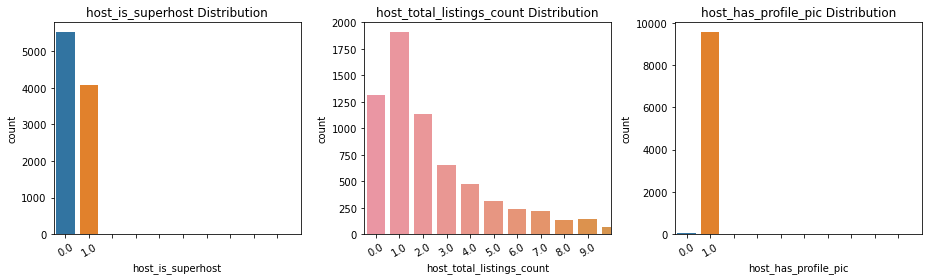

In [103]:
#Plot the modes
plt.figure(figsize=(13, 4))
i = 1
for col in h:
    plt.subplot(1, 3, i)
    sns.countplot(x=col, data=df)
    plt.title(col+' Distribution')
    plt.xticks(np.arange(0, 10, 1, dtype=np.int64), rotation=30)
    plt.xlim(right=10)
    i += 1

plt.tight_layout()

In [104]:
# Replace missing values according to histograms modes
df['host_is_superhost'] = df['host_is_superhost'].fillna(value=0) 
df['host_total_listings_count'] = df['host_total_listings_count'].fillna(value=1) 
df['host_has_profile_pic'] = df['host_has_profile_pic'].fillna(value=1) 


In [105]:
missing_zero_values_table(df)

Your selected dataframe has 1504 columns and 9671 Rows.
There are 3 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
host_identity_verified,1572,91,0.9,1663,17.2,float64
host_since_days,0,91,0.9,91,0.9,float64
bath,0,5,0.1,5,0.1,object


In [106]:
# For host identity verified the mode will also be 1
df.host_identity_verified.describe()

count    9580.000000
mean        0.835908
std         0.370378
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: host_identity_verified, dtype: float64

In [107]:
df['host_identity_verified'] = df['host_identity_verified'].fillna(value=1) 

Host since days shows the number of days ,  so for it for missing values I will replace with mean. Host acceptance rate replace with a mean as well


In [108]:
df.host_since_days.describe()

count    9580.000000
mean     1983.774635
std       900.639109
min         3.000000
25%      1440.000000
50%      2010.000000
75%      2594.250000
max      4597.000000
Name: host_since_days, dtype: float64

In [152]:
df['host_acceptance_rate'].isna().describe()

count      6094
unique        2
top       False
freq       5482
Name: host_acceptance_rate, dtype: object

In [153]:
df['host_since_days'] = df['host_since_days'].fillna(value=1984) 
df['host_acceptance_rate'] = df['host_acceptance_rate'].fillna(value=86) 

In [154]:
df['host_acceptance_rate'].isna().describe()

count      6094
unique        1
top       False
freq       6094
Name: host_acceptance_rate, dtype: object

In [111]:
df.bath = df.bath.astype(float)

In [112]:
df.bath.mode() # For replaceing missing values in baths I will use the mode

0    1.0
dtype: float64

In [113]:
df['bath'] = df['bath'].fillna(value=1) 

# Explaratory analysis

In [114]:
df["property_type"].value_counts() # take a look at which propeprty types I have

Entire residential home              2392
Entire rental unit                   1930
Entire condominium (condo)           1497
Private room in residential home      802
Entire guesthouse                     427
                                     ... 
Room in hostel                          1
Treehouse                               1
Shared room in serviced apartment       1
Private room in treehouse               1
Earth house                             1
Name: property_type, Length: 63, dtype: int64

In [115]:
# Also look among these property types to which larger groups it belongs
df.room_type.value_counts()

Entire home/apt    7886
Private room       1699
Shared room          76
Hotel room           10
Name: room_type, dtype: int64

It is easier to orient on property types. Since the goal is to predict precis for small and mid size appartments I do 2 things. First, I drop all type of rooms. Secondly I drop entire home/apt who can accomodate to large number of people (8 or more people)

In [116]:
# keep if room type is Entire home/apt
df = df.loc[lambda x: x["room_type"].isin(["Entire home/apt"])]

In [117]:
df.accommodates.value_counts() 

4     1924
6     1404
2     1403
8      753
3      573
5      538
10     348
7      247
12     198
16     164
9      111
14      81
11      51
1       45
15      26
13      20
Name: accommodates, dtype: int64

In [118]:
#only keep appartments that can accomadate up to 7 people
df = df.loc[lambda x: x["accommodates"].isin([1,2,3,4,5,6, 7])] 

In [119]:
df.accommodates.value_counts() #it is what i wanted

4    1924
6    1404
2    1403
3     573
5     538
7     247
1      45
Name: accommodates, dtype: int64

# Encoding categorical variables

In [120]:
# Look which categorical variables I still have
cat_cols = df.select_dtypes('object').columns
print('Unique Values per categorical column...')
for col in cat_cols:
    print(f'{col}: {df[col].nunique()}')

Unique Values per categorical column...
host_response_time: 5
host_acceptance_rate: 97
neighbourhood_cleansed: 97
property_type: 24
room_type: 1
price: 592


In [121]:
#Price appered to be a categorical variable, that is a mistake
df.price.head() #look at this

0    2050.00
3      74.00
4     258.00
5      78.00
6      94.00
Name: price, dtype: object

In [122]:
df.price = df.price.astype(float) #let's make it float

In [123]:
#Again look at categorical columns
cat_cols = df.select_dtypes('object').columns
print('Unique Values per categorical column...')
for col in cat_cols:
    print(f'{col}: {df[col].nunique()}') 

Unique Values per categorical column...
host_response_time: 5
host_acceptance_rate: 97
neighbourhood_cleansed: 97
property_type: 24
room_type: 1


In [124]:
#Host acceptance rate also should be a numeric variable, let's look
df.host_acceptance_rate.head() #that is because I also forgot to do it numeric

0    100%
3       0
4     84%
5     97%
6     95%
Name: host_acceptance_rate, dtype: object

In [125]:
def repl(m): return m.group(1)


df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace(
   r'(\d+)%', repl).astype(float)

In [126]:
cat_cols = df.select_dtypes('object').columns
print('Unique Values per categorical column...')
for col in cat_cols:
    print(f'{col}: {df[col].nunique()}') 

Unique Values per categorical column...
host_response_time: 5
neighbourhood_cleansed: 97
property_type: 24
room_type: 1


In [127]:
#As discussed above, in property type I am not interested anymore
df.drop(columns = 'property_type', inplace = True)

In [128]:
cat_cols = df.select_dtypes('object').columns
print('Unique Values per categorical column...')
for col in cat_cols:
    print(f'{col}: {df[col].nunique()}')  #Now good

Unique Values per categorical column...
host_response_time: 5
neighbourhood_cleansed: 97
room_type: 1


In [129]:
df.host_response_time.value_counts()

within an hour        4052
within a few hours     851
0                      670
within a day           423
a few days or more     138
Name: host_response_time, dtype: int64

In [130]:
# Only 2 categorical variables left

# host response type  and neighbourhood as factors

df["host_response_time"] = df["host_response_time"].astype("category")
df["neighbourhood_cleansed"] = df["neighbourhood_cleansed"].astype("category")

In [131]:
#Let's at price - there seems to be some very big prices on the higher tail
df.price.describe()

count     6134.000000
mean       220.453375
std        493.444887
min         35.000000
25%        120.000000
50%        164.000000
75%        248.000000
max      24999.000000
Name: price, dtype: float64

In [132]:
df.shape

(6134, 1503)

# Sample reduction and feature engineering

In [133]:
#Since I am interested in small and medium size appartments, I will drop observations which are more expensive than 1000
df =  df.loc[lambda x: x.price < 1000]

In [134]:
df.shape

(6094, 1503)

In [135]:
# Squares and further values to create
df = df.assign(
    n_accommodates2=lambda x: x["accommodates"] ** 2,
    ln_accommodates=lambda x: np.log(x["accommodates"]),
    ln_accommodates2=lambda x: np.log(x["accommodates"]) ** 2,
    ln_beds=lambda x: np.log(x["beds"]),
    ln_bedrooms =  lambda x: np.log(x["bedrooms"]),
    ln_number_of_reviews=lambda x: np.log(x["number_of_reviews"] + 1),
)

In [136]:
# Pool accomodations with 0,1,2,10 bathrooms

bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 10)], closed="left")
bath = pd.cut(df["bath"].to_list(), bins, labels=["0", "1", "2"])
bath.categories = [0, 1, 2]
df["bath"] = bath

bath.value_counts(dropna=False)

0      17
1    4422
2    1655
dtype: int64

I also want to create variable distance from the city center. For this I will use coordinates of Downtown San Diego, it is also called a historical centre where most of the attractions are located. 

In [137]:
#Coordinates of San Diego city center
coords = (32.715738, -117.161084)
coord1 = 32.715738
coord2 = -117.161084


In [138]:
list(df.columns)

['Unnamed: 0',
 'id',
 'host_id',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'room_type',
 'accommodates',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'reviews_per_month',
 'host_since_days',
 'first_review_days',
 'l

In [139]:
#check whether coordinates columns have missing values
df.latitude.isna().describe()

count      6094
unique        1
top       False
freq       6094
Name: latitude, dtype: object

In [140]:
df.longitude.isna().describe()

count      6094
unique        1
top       False
freq       6094
Name: longitude, dtype: object

In [141]:
#check their type
type(df.longitude)

pandas.core.series.Series

In [142]:
#Calculate the distance between SD city center and airbnb location

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km


for index, row in df.iterrows():
    df.loc[index, 'distance'] = haversine(coord1, coord2, row['longitude'], row['latitude'])

In [143]:
df.distance.head()

3    10953.785454
4    10959.527318
5    10959.314707
6    10959.900548
7    10958.305569
Name: distance, dtype: float64

In [144]:
df.shape

(6094, 1510)

In [146]:
drops_l = ['longitude','latitude']

In [147]:
#Drop columns for latitude and longtitude
df.drop(columns = drops_l, inplace = True) 

In [148]:
df.shape

(6094, 1508)

At this point I change to colab to run a random forest

In [156]:
df.to_csv('airbnb_colab.csv', index='False')

In [150]:
for col in df:
    print(col)

Unnamed: 0
id
host_id
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_total_listings_count
host_has_profile_pic
host_identity_verified
neighbourhood_cleansed
room_type
accommodates
bedrooms
beds
price
minimum_nights
maximum_nights
has_availability
availability_30
availability_60
availability_90
availability_365
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
instant_bookable
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
reviews_per_month
host_since_days
first_review_days
last_review_days
bath
n_amenities

1 travel size bottle conditioner
1 travel size bottle shampoo
100% pure plant extracts body wash by kirkland signature body soap
100% vegan & cruelty-free
120\

variety  conditioner
variety  shampoo
variety body soap
variety conditioner
various  body soap
various body soap
various boutique brands body soap
various brands body soap
various brands conditioner
various brands shampoo
various conditioner
various shampoo
vegan body soap
vegan conditioner
vegan shampoo
viking  stainless steel gas stove
viking stainless steel gas stove
viking stainless steel oven
viking stove with six burners stove
vintage early 50s gas stove
vissani refrigerator
vizio surround sound system
w/ icemaker & filtered water refrigerator
walk-in closet
walmart body soap
walmart conditioner
walmart shampoo
wardrobe
washer
washer \u2013\u00a0in building
washer \u2013\u00a0in unit
water dispenser does not work at the moment refrigerator
waterfront
we have several brands of body soap available. body soap
we provide guests a basic \starter kit\ of toiletries
western holly
wet bar
whirldbool oven
whirlpool  refrigerator
whirlpool  stainless steel gas stove
whirlpool electric stov

In [155]:
missing_zero_values_table(df)

Your selected dataframe has 1508 columns and 6094 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
